# GenSAM DEMO

### Environment Prepartion
The virtualenv environment named GenSAM_LLaVA needs to be created first following README.md.
Complete the following steps in the shell before opening the jupyter notebook.
```
pip install notebook 
pip install ipykernel ipywidgets
python -m ipykernel install --user --name GenSAM_LLaVA
```
Then select the 'GenSAM_LLaVA' kernel in the running notebook.


In [1]:
from pickle import FALSE
from socket import IPPROTO_UDP
import torch
import cv2
import numpy as np
from PIL import Image
from  matplotlib import pyplot as plt
import argparse
import yaml
import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from utils_model import get_text_from_img, get_mask, fuse_mask
from utils_model import get_edge_img, DotDict, printd, mkdir
import os

In [2]:
## configs setting
args_dict = {
    'config': 'config/CHAMELEON_LLaVA1.5.yaml', # set configs file used in this demo
    'visualization': True # keep True for the demo
}

In [3]:
class argObject:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
args = argObject(**args_dict)
            
device = "cuda" if torch.cuda.is_available() else "cpu"
with open(args.config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
data_args = config['test_dataset']
model_args = DotDict(config)

## get data
dataset = datasets.make(data_args['dataset'])
dataset = datasets.make(data_args['wrapper'], args={'dataset': dataset})
loader = DataLoader(dataset, batch_size=data_args['batch_size'],
                    num_workers=8)
paths_img = dataset.dataset.paths_img
data_len = len(paths_img)
printd(f"dataset size:\t {len(paths_img)}")

2023-12-25 14:11:37	 dataset size:	 76


In [4]:
## load pretrained model  
# CLIP surgery, SAM
from segment_anything import sam_model_registry, SamPredictor
from clip.clip_surgery_model import CLIPSurgery
import clip
sam = sam_model_registry[model_args.sam_model_type](checkpoint=model_args.sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)
clip_params={ 'attn_qkv_strategy':model_args.clip_attn_qkv_strategy}
clip_model, _ = clip.load(model_args.clip_model, device=device, params=clip_params)
clip_model.eval()
# VLM
llm_dict=None
if model_args.llm=='blip':
    from lavis.models import load_model_and_preprocess
    # blip_model_type="pretrain_opt2.7b"
    blip_model_type="pretrain_opt6.7b" 
    printd(f'loading BLIP ({blip_model_type})...')
    BLIP_model, BLIP_vis_processors, _ = load_model_and_preprocess(name="blip2_opt", 
                                                                   model_type=blip_model_type, 
                                                                   is_eval=True, 
                                                                   device=device)
    BLIP_dict = {"demo_data/9.jpg": 'lizard in the middle',}
    llm_dict = {
        'model': BLIP_model,
        'vis_processors':  BLIP_vis_processors,
    }
elif model_args.llm=='LLaVA' or model_args.llm=='LLaVA1.5':
    from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
    from llava.conversation import conv_templates, SeparatorStyle
    from llava.model.builder import load_pretrained_model
    from llava.utils import disable_torch_init
    from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
    disable_torch_init()
    if model_args.llm=='LLaVA':
        model_path = 'liuhaotian/llava-llama-2-13b-chat-lightning-preview'
    else:
        model_path = 'liuhaotian/llava-v1.5-13b'
    print(f'llava pretrained model: {model_path}')
    model_path = os.path.expanduser(model_path)
    model_args.model_name = get_model_name_from_path(model_path)
    tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_args.model_base, model_args.model_name)
    if 'llama-2' in model_args.model_name.lower(): # from clip.py
        conv_mode = "llava_llama_2"
    elif "v1" in model_args.model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_args.model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"
    model_args.conv_mode = conv_mode
    llm_dict = {
        'model': model,
        'vis_processors':  image_processor,
        'tokenizer': tokenizer,
        'conv_mode': model_args.conv_mode,
        'temperature': model_args.temperature,
        'w_caption': model_args.LLaVA_w_caption,
    }
else:
    exit(f'unknow LLM: {model_args.llm}')

llava pretrained model: liuhaotian/llava-v1.5-13b


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
for item in paths_img:
    print(item)

./data/CHAMELEON_TestingDataset/Image/animal-1.jpg
./data/CHAMELEON_TestingDataset/Image/animal-10.jpg
./data/CHAMELEON_TestingDataset/Image/animal-11.jpg
./data/CHAMELEON_TestingDataset/Image/animal-12.jpg
./data/CHAMELEON_TestingDataset/Image/animal-13.jpg
./data/CHAMELEON_TestingDataset/Image/animal-14.jpg
./data/CHAMELEON_TestingDataset/Image/animal-15.jpg
./data/CHAMELEON_TestingDataset/Image/animal-16.jpg
./data/CHAMELEON_TestingDataset/Image/animal-17.jpg
./data/CHAMELEON_TestingDataset/Image/animal-18.jpg
./data/CHAMELEON_TestingDataset/Image/animal-19.jpg
./data/CHAMELEON_TestingDataset/Image/animal-2.jpg
./data/CHAMELEON_TestingDataset/Image/animal-20.jpg
./data/CHAMELEON_TestingDataset/Image/animal-21.jpg
./data/CHAMELEON_TestingDataset/Image/animal-22.jpg
./data/CHAMELEON_TestingDataset/Image/animal-23.jpg
./data/CHAMELEON_TestingDataset/Image/animal-24.jpg
./data/CHAMELEON_TestingDataset/Image/animal-25.jpg
./data/CHAMELEON_TestingDataset/Image/animal-26.jpg
./data/CHAMELE

In [7]:
# choose the image you want to visualize from the printed path list here.
# do not need to load the pretrained model again
img_path = './data/CHAMELEON_TestingDataset/Image/animal-1.jpg'
assert img_path in paths_img

In [8]:
## infer GenSAM
pil_img = Image.open(img_path).convert("RGB")

print(model_args.llm)

text, text_bg = get_text_from_img(pil_img, model_args.prompt_q, llm_dict,
                                  model_args.use_gene_prompt, model_args.clip_use_bg_text, model_args)
mask_l, mask_logit_origin_l, num_l, vis_dict = get_mask(pil_img, text, sam_predictor, clip_model, 
                                                        model_args, device,  
                                                        llm_dict=llm_dict, 
                                                        text_bg=text_bg,
                                                        is_visualization=args.visualization )


LLaVA1.5
A lion is camouflaged in the tall grass.
Lion
Grass
A lion is hidden in the tall grass, looking at the camera.
Lion
Grass
A lion is hidden in the tall grass, looking to the side.
Lion
Grass
A lion is hidden in the tall grass, blending in with its surroundings.
Lion
Grass
A lion is hidden in the tall grass, looking at the camera.
Lion
Grass
A lion is hidden in the tall grass.
Lion
Grass
iter 1 text:	['Lion', 'Lion', 'Lion'], ['Grass', 'Grass', 'Grass']
A lion is hidden in the tall grass, blending in with its surroundings.
Lion
Grass
A lion is hiding in the tall grass.
Lion
Grass
A lion is hidden in the tall grass, looking to the side.
Lion
Grass
iter 2 text:	['Lion', 'Lion', 'Lion'], ['Grass', 'Grass', 'Grass']
A lion is laying in the tall grass, partially hidden by the tall grass and a tree.
Lion
Grass
A lion is hiding in the tall grass, partially obscured by the tall grass.
Lion
Grass
A lion is hidden in the tall grass.
Lion
Grass
iter 3 text:	['Lion', 'Lion', 'Lion'], ['Gras

2023-12-25 14:13:23	 ./data/CHAMELEON_TestingDataset/Image/animal-1.jpg


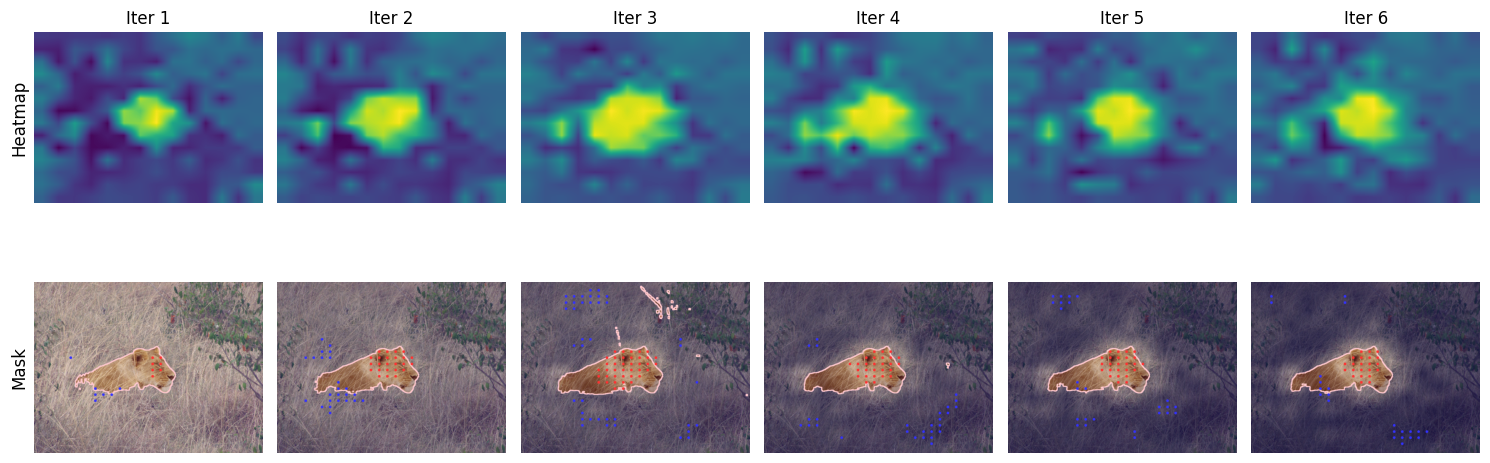

In [9]:
## visualization
vis_input_img = vis_dict['vis_input_img']
vis_mask_l = vis_dict['vis_mask_l']
points_l = vis_dict['points_l']
labels_l = vis_dict['labels_l']
sm_fg_bg_l = vis_dict['sm_fg_bg_l']
img_name = img_path.split('/')[-1][:-4]
vis_pt_l = [np.expand_dims(255*vis_mask_l[i], axis=2).repeat(3, axis=2) for i in range(len(vis_mask_l))]
for i in range(len(vis_mask_l)):
    vis_input_img[i] = get_edge_img(255*vis_mask_l[i], vis_input_img[i],)
for j in range(len(points_l)):
    for i, [x, y] in enumerate(points_l[j]):
        if labels_l[j][i] == 0:
            clr = (50, 50, 255)
        elif labels_l[j][i] == 1:
            clr = (255, 50, 50)
        else:
            clr = (0, 255, 102)
        cv2.circle(vis_pt_l[j], (x, y), 6, clr, -1)
        cv2.circle(vis_input_img[j], (x, y), 6, clr, -1)

## plot
iter_num = len(vis_input_img)-1
fig, axes = plt.subplots(nrows=2, ncols=iter_num, figsize=(15, 6))

cols = ['Iter {}'.format(col) for col in range(1, iter_num+1)]
rows = ['Heatmap', 'Mask']


row = 0
for col in range(iter_num):
    ax = axes[row, col]
    ax.imshow(sm_fg_bg_l[col])
    ax.axis('off')

row = 1
for col in range(iter_num):
    ax = axes[row, col]
    ax.imshow(vis_input_img[col])
    ax.axis('off')
    
for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.axis('on')
    ax.set_ylabel(row, rotation='vertical', size='large')
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    for spine in ax.spines.values():
        spine.set_visible(False)
     
plt.tight_layout()

printd(img_path)
plt.show()
        